## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally work on a transformer part.

In [63]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from tqdm import tqdm
import random
import json

%load_ext autoreload
%autoreload 2
from data_utils import MLDataset, collate_fn
from modeling import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (Optional) Sample Visualization
You can see actual sample images and correct answers. Additional matplotlib package is needed.

In [64]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

id_to_char = {}
alphabets = "abcdefghijklmnopqrstuvwxyz"
for i, c in enumerate(alphabets):
    id_to_char[i+1] = c

Answer: defines ([4, 5, 6, 9, 14, 5, 19])
Input image sequence:


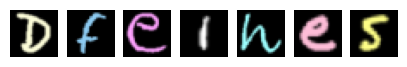

In [65]:
# Just for reference: see actual samples
idx = 20000
sample = np.load(f'./data_final/imgs/train/{idx}.npy')
with open('./data_final/labels/train.json', 'r') as f:
    sample_target = json.load(f)[str(idx)]
    
tgt_char = ""
for i in sample_target:
    tgt_char += id_to_char[i]


print(f"Answer: {tgt_char} ({sample_target})")
print("Input image sequence:")

plt.figure(figsize=(5, len(sample)))
for i, img in enumerate(sample):    
    plt.subplot(1, len(sample), i+1)
    plt.axis("off")
    plt.imshow(img)

## Device and seed setting

In [66]:
assert torch.cuda.is_available()

# Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2 # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 8

## Model loading and training

In [67]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128

train_ds = MLDataset('data_final/imgs/train', 'data_final/labels/train.json')
#train_ds = MLDataset('data_final/imgs/train_challenge', 'data_final/labels/train_challenge.json')
valid_ds = MLDataset('data_final/imgs/valid_normal', 'data_final/labels/valid_normal.json')
challenge_ds = MLDataset('data_final/imgs/valid_challenge', 'data_final/labels/valid_challenge.json')

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
challenge_dl = DataLoader(challenge_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

In [68]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 256,
    'n_rnn_layers': 1,
    'rnn_dropout': 0.5,
    'embedding_dim': 90

    #teacherforcing ratio
}

In [69]:
model = Seq2SeqModelChallenge(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################
model_optim = optim.Adam(model.parameters(), lr=0.003)

# Loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # 0번 인덱스를 패딩으로 사용

# Scheduler
scheduler = StepLR(model_optim, step_size=1, gamma=0.9)
# NOTE: you can define additional components like lr_scheduler, ...
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Seq2SeqModelChallenge(
  (encoder): Encoder(
    (cnn): CustomCNN(
      (conv1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (conv3): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [70]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 100
max_epoch = 10

In [71]:
def train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=None, save_path='./challenge_model.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]
        # ...

    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    best_valid_loss = 1e+10 if loaded_best_valid_loss == -1 else loaded_best_valid_loss

    losses = []
    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        step = 0
        train_loss = 0
        print_loss = 0
        model.train()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data = data.to(device) # (B, T, H, W, C)
            target = target.to(device) # (B, T)

            # start tokens should be located at the first position of the decoder input
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)   #ind 0 is for <pad>, idx 27 is for <s>
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 5: implement loss calculation and optimization part
            # You can utilize teacher-forcing strategy to this part

            model_optim.zero_grad()

            # Prepare decoder input (start tokens + target without last token)
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1) # is equal to input_sep in Decoder_forward
            # Forward pass
            output, _,  = model(data, lengths, decoder_input)

            # Calculate loss
            loss = loss_fn(output.permute(0, 2, 1), target)  # (B, N_vocab, T) -> (B, T, N_vocab) vs (B, T)
            loss.backward()
            model_optim.step()



            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            train_loss += loss.detach().cpu().item()
            step += 1
            print_loss += loss.detach().cpu().item()
            if (batch_idx + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', print_loss/print_interval)
                losses.append(print_loss/print_interval)
                print_loss = 0

        train_loss_avg = train_loss / (batch_idx+1)
        print(f"epoch {epoch + 1}, train loss: {train_loss_avg}")

        valid_loss = 0
        model.eval()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(valid_dl)):
            with torch.no_grad():
                data = data.to(device) # (B, T, H, W, C)
                target = target.to(device) # (B, T)

                # start tokens should be located at the first position of the decoder input
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Implement loss calculation for valid batch (same as problem 5)
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)

                # Forward pass
                output, _ = model(data, lengths, decoder_input)

                # Calculate loss
                loss = loss_fn(output.permute(0, 2, 1), target)  # (Batch_size, N_vocab, Sequence_length) vs (Batch_size, Sequence_length)
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                valid_loss += loss.cpu().item()
        valid_loss /= (batch_idx + 1)
        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Save your states
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": best_valid_loss,
                # ...
            }
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            torch.save(state, save_path)
            best_valid_loss = valid_loss
        print('valid epoch: %d, valid loss: %.4f, best valid loss: %.4f' % (epoch + 1, valid_loss, best_valid_loss))

    return losses

In [72]:
load_path = './challenge_model.pt'
losses = train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./challenge_model.pt')
print(kwargs)
plt.plot(losses)

 19%|█▉        | 100/531 [01:05<04:33,  1.57it/s]

epoch: 3 step: 101 loss: 0.10118663184344769


 38%|███▊      | 200/531 [02:09<03:28,  1.59it/s]

epoch: 3 step: 201 loss: 0.11083731785416603


 56%|█████▋    | 300/531 [03:14<02:22,  1.62it/s]

epoch: 3 step: 301 loss: 0.10201592691242695


 75%|███████▌  | 400/531 [04:19<01:28,  1.48it/s]

epoch: 3 step: 401 loss: 0.09827819310128688


 94%|█████████▍| 500/531 [05:27<00:19,  1.59it/s]

epoch: 3 step: 501 loss: 0.09066765807569027


100%|██████████| 531/531 [05:48<00:00,  1.52it/s]


epoch 3, train loss: 0.1001517969252026


100%|██████████| 76/76 [00:50<00:00,  1.52it/s]


New best valid loss, saving model
valid epoch: 3, valid loss: 0.0950, best valid loss: 0.0950


 19%|█▉        | 100/531 [01:11<05:06,  1.41it/s]

epoch: 4 step: 101 loss: 0.07738258175551892


 38%|███▊      | 200/531 [02:23<04:02,  1.36it/s]

epoch: 4 step: 201 loss: 0.07426304552704095


 56%|█████▋    | 300/531 [03:35<02:39,  1.45it/s]

epoch: 4 step: 301 loss: 0.07475623115897179


 75%|███████▌  | 400/531 [04:48<01:37,  1.34it/s]

epoch: 4 step: 401 loss: 0.07445618692785501


 94%|█████████▍| 500/531 [06:01<00:23,  1.35it/s]

epoch: 4 step: 501 loss: 0.0723377650603652


100%|██████████| 531/531 [06:24<00:00,  1.38it/s]


epoch 4, train loss: 0.07452486652579236


100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


New best valid loss, saving model
valid epoch: 4, valid loss: 0.0783, best valid loss: 0.0783


 19%|█▉        | 100/531 [01:07<04:43,  1.52it/s]

epoch: 5 step: 101 loss: 0.058901411592960355


 38%|███▊      | 200/531 [02:14<03:38,  1.51it/s]

epoch: 5 step: 201 loss: 0.06137229759246111


 56%|█████▋    | 300/531 [03:22<02:51,  1.34it/s]

epoch: 5 step: 301 loss: 0.06097464665770531


 75%|███████▌  | 400/531 [04:29<01:30,  1.44it/s]

epoch: 5 step: 401 loss: 0.06613647423684597


 94%|█████████▍| 500/531 [05:38<00:21,  1.46it/s]

epoch: 5 step: 501 loss: 0.06694642696529626


100%|██████████| 531/531 [06:00<00:00,  1.47it/s]


epoch 5, train loss: 0.06303543103560665


100%|██████████| 76/76 [00:52<00:00,  1.44it/s]


New best valid loss, saving model
valid epoch: 5, valid loss: 0.0743, best valid loss: 0.0743


 19%|█▉        | 100/531 [01:11<05:01,  1.43it/s]

epoch: 6 step: 101 loss: 0.050574523732066154


 38%|███▊      | 200/531 [02:24<03:48,  1.45it/s]

epoch: 6 step: 201 loss: 0.05180594723671675


 56%|█████▋    | 300/531 [03:38<03:01,  1.28it/s]

epoch: 6 step: 301 loss: 0.052154898084700106


 75%|███████▌  | 400/531 [04:51<01:33,  1.40it/s]

epoch: 6 step: 401 loss: 0.05295808561146259


 94%|█████████▍| 500/531 [06:06<00:23,  1.32it/s]

epoch: 6 step: 501 loss: 0.05683508226647973


100%|██████████| 531/531 [06:29<00:00,  1.36it/s]


epoch 6, train loss: 0.05313127625754661


100%|██████████| 76/76 [00:53<00:00,  1.41it/s]


New best valid loss, saving model
valid epoch: 6, valid loss: 0.0713, best valid loss: 0.0713


 19%|█▉        | 100/531 [01:11<05:08,  1.40it/s]

epoch: 7 step: 101 loss: 0.04373526062816382


 38%|███▊      | 200/531 [02:24<03:57,  1.39it/s]

epoch: 7 step: 201 loss: 0.04344182351604104


 56%|█████▋    | 300/531 [03:38<02:58,  1.29it/s]

epoch: 7 step: 301 loss: 0.04802253894507885


 75%|███████▌  | 400/531 [04:53<01:32,  1.41it/s]

epoch: 7 step: 401 loss: 0.04983061613515019


 94%|█████████▍| 500/531 [06:08<00:23,  1.34it/s]

epoch: 7 step: 501 loss: 0.051051747798919675


100%|██████████| 531/531 [06:31<00:00,  1.36it/s]


epoch 7, train loss: 0.047479625658014626


100%|██████████| 76/76 [00:52<00:00,  1.44it/s]


New best valid loss, saving model
valid epoch: 7, valid loss: 0.0691, best valid loss: 0.0691


 19%|█▉        | 100/531 [01:12<05:11,  1.39it/s]

epoch: 8 step: 101 loss: 0.040341222248971464


 38%|███▊      | 200/531 [02:24<03:59,  1.38it/s]

epoch: 8 step: 201 loss: 0.044140906184911725


 56%|█████▋    | 300/531 [03:37<02:37,  1.47it/s]

epoch: 8 step: 301 loss: 0.043567284513264894


 75%|███████▌  | 400/531 [04:49<01:33,  1.40it/s]

epoch: 8 step: 401 loss: 0.04293338904157281


 94%|█████████▍| 500/531 [06:03<00:24,  1.28it/s]

epoch: 8 step: 501 loss: 0.04628497565165162


100%|██████████| 531/531 [06:27<00:00,  1.37it/s]


epoch 8, train loss: 0.04354583284345836


100%|██████████| 76/76 [00:54<00:00,  1.38it/s]


New best valid loss, saving model
valid epoch: 8, valid loss: 0.0604, best valid loss: 0.0604


 19%|█▉        | 100/531 [01:12<05:12,  1.38it/s]

epoch: 9 step: 101 loss: 0.03526668787002563


 26%|██▋       | 140/531 [01:42<04:46,  1.37it/s]


KeyboardInterrupt: 

In [10]:
load_path = None
train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./challenge_model.pt')

  0%|          | 0/531 [00:00<?, ?it/s]c:\Users\CafeAlle\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\CafeAlle\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 19%|█▉        | 100/531 [01:09<05:08,  1.39it/s]

epoch: 1 step: 101 loss: 1.9950614941120148


 38%|███▊      | 200/531 [02:17<03:28,  1.59it/s]

epoch: 1 step: 201 loss: 1.1991788774728775


 56%|█████▋    | 300/531 [03:26<02:49,  1.36it/s]

epoch: 1 step: 301 loss: 0.7286568254232406


 75%|███████▌  | 400/531 [04:35<01:29,  1.46it/s]

epoch: 1 step: 401 loss: 0.4177131077647209


 94%|█████████▍| 500/531 [05:42<00:20,  1.50it/s]

epoch: 1 step: 501 loss: 0.2958542263507843


100%|██████████| 531/531 [06:03<00:00,  1.46it/s]


epoch 1, train loss: 0.8881923628448317


100%|██████████| 76/76 [00:51<00:00,  1.46it/s]


New best valid loss, saving model
valid epoch: 1, valid loss: 0.2450, best valid loss: 0.2450


 19%|█▉        | 100/531 [01:12<05:25,  1.33it/s]

epoch: 2 step: 101 loss: 0.21669285655021667


 38%|███▊      | 200/531 [02:24<03:53,  1.42it/s]

epoch: 2 step: 201 loss: 0.19808955892920493


 56%|█████▋    | 300/531 [03:35<02:37,  1.47it/s]

epoch: 2 step: 301 loss: 0.17664508149027824


 75%|███████▌  | 400/531 [04:46<01:32,  1.42it/s]

epoch: 2 step: 401 loss: 0.1609877137839794


 94%|█████████▍| 500/531 [05:57<00:21,  1.43it/s]

epoch: 2 step: 501 loss: 0.15133695475757122


100%|██████████| 531/531 [06:19<00:00,  1.40it/s]


epoch 2, train loss: 0.17870467424168202


100%|██████████| 76/76 [00:53<00:00,  1.43it/s]


New best valid loss, saving model
valid epoch: 2, valid loss: 0.1465, best valid loss: 0.1465


 19%|█▉        | 100/531 [01:14<05:22,  1.34it/s]

epoch: 3 step: 101 loss: 0.12422879047691822


 38%|███▊      | 200/531 [02:26<04:19,  1.28it/s]

epoch: 3 step: 201 loss: 0.12136193268001079


 56%|█████▋    | 300/531 [03:38<02:36,  1.48it/s]

epoch: 3 step: 301 loss: 0.11833553284406662


 75%|███████▌  | 400/531 [04:49<01:35,  1.37it/s]

epoch: 3 step: 401 loss: 0.11256021924316884


 94%|█████████▍| 500/531 [06:00<00:21,  1.42it/s]

epoch: 3 step: 501 loss: 0.11212397739291191


100%|██████████| 531/531 [06:22<00:00,  1.39it/s]


epoch 3, train loss: 0.11724033167413848


100%|██████████| 76/76 [00:53<00:00,  1.43it/s]


New best valid loss, saving model
valid epoch: 3, valid loss: 0.1143, best valid loss: 0.1143


 19%|█▉        | 100/531 [01:13<05:08,  1.40it/s]

epoch: 4 step: 101 loss: 0.09168079804629087


 38%|███▊      | 200/531 [02:25<03:48,  1.45it/s]

epoch: 4 step: 201 loss: 0.09421482309699059


 56%|█████▋    | 300/531 [03:37<02:42,  1.42it/s]

epoch: 4 step: 301 loss: 0.09245381996035576


 75%|███████▌  | 400/531 [04:48<01:36,  1.36it/s]

epoch: 4 step: 401 loss: 0.0915981525182724


 94%|█████████▍| 500/531 [06:01<00:21,  1.42it/s]

epoch: 4 step: 501 loss: 0.08953540347516536


100%|██████████| 531/531 [06:23<00:00,  1.38it/s]


epoch 4, train loss: 0.09162810470088054


100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


New best valid loss, saving model
valid epoch: 4, valid loss: 0.0971, best valid loss: 0.0971


 19%|█▉        | 100/531 [01:11<05:03,  1.42it/s]

epoch: 5 step: 101 loss: 0.07289504636079074


 38%|███▊      | 200/531 [02:24<04:08,  1.33it/s]

epoch: 5 step: 201 loss: 0.07324205748736859


 56%|█████▋    | 300/531 [03:35<02:39,  1.44it/s]

epoch: 5 step: 301 loss: 0.07466580763459206


 75%|███████▌  | 400/531 [04:45<01:32,  1.42it/s]

epoch: 5 step: 401 loss: 0.07234869226813316


 94%|█████████▍| 500/531 [05:56<00:21,  1.41it/s]

epoch: 5 step: 501 loss: 0.0738017788156867


100%|██████████| 531/531 [06:18<00:00,  1.40it/s]


epoch 5, train loss: 0.07348159053792612


100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


New best valid loss, saving model
valid epoch: 5, valid loss: 0.0907, best valid loss: 0.0907


 19%|█▉        | 100/531 [01:10<05:11,  1.38it/s]

epoch: 6 step: 101 loss: 0.059344519078731534


 38%|███▊      | 200/531 [02:20<03:49,  1.44it/s]

epoch: 6 step: 201 loss: 0.06168021896854043


 56%|█████▋    | 300/531 [03:31<02:43,  1.41it/s]

epoch: 6 step: 301 loss: 0.061132054179906845


 75%|███████▌  | 400/531 [04:43<01:34,  1.39it/s]

epoch: 6 step: 401 loss: 0.06337939068675041


 94%|█████████▍| 500/531 [05:54<00:22,  1.36it/s]

epoch: 6 step: 501 loss: 0.06749340899288654


100%|██████████| 531/531 [06:17<00:00,  1.41it/s]


epoch 6, train loss: 0.06325058431738177


100%|██████████| 76/76 [00:54<00:00,  1.40it/s]


valid epoch: 6, valid loss: 0.1296, best valid loss: 0.0907


 19%|█▉        | 100/531 [01:11<05:09,  1.39it/s]

epoch: 7 step: 101 loss: 0.05739087561145425


 38%|███▊      | 200/531 [02:23<03:43,  1.48it/s]

epoch: 7 step: 201 loss: 0.05348238034173846


 56%|█████▋    | 300/531 [03:35<02:47,  1.38it/s]

epoch: 7 step: 301 loss: 0.05541173193603754


 75%|███████▌  | 400/531 [04:47<01:34,  1.38it/s]

epoch: 7 step: 401 loss: 0.05593657791614533


 94%|█████████▍| 500/531 [05:58<00:22,  1.39it/s]

epoch: 7 step: 501 loss: 0.05663578491657972


100%|██████████| 531/531 [06:19<00:00,  1.40it/s]


epoch 7, train loss: 0.055930561342201215


100%|██████████| 76/76 [00:53<00:00,  1.42it/s]


New best valid loss, saving model
valid epoch: 7, valid loss: 0.0795, best valid loss: 0.0795


 19%|█▉        | 100/531 [01:11<05:07,  1.40it/s]

epoch: 8 step: 101 loss: 0.04376602310687303


 38%|███▊      | 200/531 [02:22<03:49,  1.44it/s]

epoch: 8 step: 201 loss: 0.044841723367571834


 56%|█████▋    | 300/531 [03:33<02:41,  1.43it/s]

epoch: 8 step: 301 loss: 0.048083040975034234


 75%|███████▌  | 400/531 [04:43<01:29,  1.46it/s]

epoch: 8 step: 401 loss: 0.04923162169754505


 94%|█████████▍| 500/531 [05:54<00:21,  1.44it/s]

epoch: 8 step: 501 loss: 0.05259614922106266


100%|██████████| 531/531 [06:16<00:00,  1.41it/s]


epoch 8, train loss: 0.048181235818315134


100%|██████████| 76/76 [00:53<00:00,  1.43it/s]


New best valid loss, saving model
valid epoch: 8, valid loss: 0.0756, best valid loss: 0.0756


 19%|█▉        | 100/531 [01:11<04:58,  1.44it/s]

epoch: 9 step: 101 loss: 0.037979753827676176


 38%|███▊      | 200/531 [02:22<03:51,  1.43it/s]

epoch: 9 step: 201 loss: 0.04163299147039652


 56%|█████▋    | 300/531 [03:34<02:47,  1.38it/s]

epoch: 9 step: 301 loss: 0.04643441017717123


 75%|███████▌  | 400/531 [04:48<01:36,  1.36it/s]

epoch: 9 step: 401 loss: 0.0464785635843873


 94%|█████████▍| 500/531 [06:01<00:22,  1.39it/s]

epoch: 9 step: 501 loss: 0.04739017516374588


100%|██████████| 531/531 [06:23<00:00,  1.39it/s]


epoch 9, train loss: 0.044397308754255876


100%|██████████| 76/76 [00:55<00:00,  1.37it/s]


New best valid loss, saving model
valid epoch: 9, valid loss: 0.0752, best valid loss: 0.0752


  1%|▏         | 7/531 [00:05<06:44,  1.29it/s]


KeyboardInterrupt: 

## Model evaluation

In [11]:
kwargs_generate = {
    # you can add arguments for your model's generate function
    'max_length': 12
}

In [12]:
# Do not modify this cell!

def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i+1] = c

    results = []
    labels = []    
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):       
        data = data.to(device) # (B, T, H, W, C)
        target = target.to(device) # (B, T)
        
        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
        with torch.no_grad():
            generated_tok = model.generate(data, lengths, start_tokens, **kwargs_generate) # (B, T)
            
        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            results.append(decoded)
    
            decoded = ""
            for j in target[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)
        
    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [13]:
# load and evaluate your model
load_path = './challenge_model.pt'
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

print("Evaluation with chllenge set")
results, labels = eval(challenge_dl, load_path)

Evaluation with validation set


100%|██████████| 76/76 [04:21<00:00,  3.44s/it]


Accuracy: 0.84467
Evaluation with chllenge set


100%|██████████| 69/69 [03:58<00:00,  3.46s/it]

Accuracy: 0.76922


In [ ]:
#이거 main_challenge.ipynb를 5epoch만 train한 것.
#train할 때 loss 0.1이하로 떨어졌었음